<a href="https://colab.research.google.com/github/Ignas12345/Magistro_projektas/blob/main/knygutes/paskutinis_bandymas_klasifikuoti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
# uzkraunam neapdorotus duomenis
url = 'https://raw.githubusercontent.com/Ignas12345/Magistro_projektas/refs/heads/main/counts_combined.csv'
df = pd.read_csv(url)
full_gene_names = df["miRNA_ID"].to_numpy()
df_trimmed = df.drop(df.columns[0], axis=1)
full_data = (df_trimmed.to_numpy(dtype=np.int32))
print(np.shape(full_data))

(1881, 139)


In [3]:

# Papildomas filtravimas, jei reikia
#Calculate the percentage of values less than 100 for each row
min_counts = 1000
max_below_min_counts = 0.98
percent_less_than_100 = np.sum(full_data < min_counts, axis=1) / full_data.shape[1]

# Keep only rows where values less than min_counts occur max_below_min_counts or less of the time
filtered_data = full_data[percent_less_than_100 <= max_below_min_counts]
filtered_gene_names = full_gene_names[percent_less_than_100 <= max_below_min_counts]

# Display the filtered array
print(np.shape(filtered_data))

(300, 139)


In [4]:
X = filtered_data.T
gene_ids = filtered_gene_names
print(np.shape(X))

(139, 300)


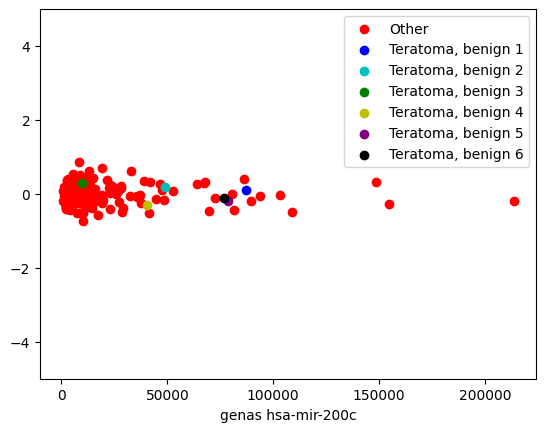

In [27]:
try:
  #i=np.where(gene_ids == 'hsa-mir-520f')[0][0]
  i = 105


  plt.scatter(X[6:139, i], np.random.normal(scale=0.3, size = len(X[6:139, 0])), c = 'r', label = 'Other')
  plt.scatter(X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
  plt.scatter(X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
  plt.scatter(X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
  plt.scatter(X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
  plt.scatter(X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
  plt.scatter(X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
  plt.xlabel('genas ' + str(gene_ids[i]))
  plt.ylim(-5, 5)
  plt.legend()
  plt.show()
except:
    print('Sitas genas isfiltruotas - reiktu pakeisti X matrica')

In [5]:
num_samples = X.shape[0]
labels = torch.zeros(num_samples, dtype=torch.float32)
labels[6:] = 1

features = torch.tensor(X, dtype=torch.float32)
mean_X = features.mean(dim=0)
std_X = features.std(dim=0)


In [7]:


#jeigu norim, galim istrinti isskirtini elementa
num_samples = X.shape[0] - 1
features = torch.tensor(np.delete(X, 2, axis = 0), dtype=torch.float32)
labels = torch.zeros(num_samples, dtype=torch.float32)
labels[5:] = 1
# cia baigiasi isskirtinio meginio istrynimas (uzkomentuoti sias elutes jeigu to nenorim)


#netikri papildomi treniravimo duomenys
benign_features = features[np.where(labels == 0)]
benign_labels = labels[np.where(labels == 0)]


# Duplicate benign samples with slight noise
for i in range(10):
  augmented_features = benign_features + 0.01 * torch.randn_like(benign_features)
  features = torch.cat([features, augmented_features])
  labels = torch.cat([labels, benign_labels])

features = (features - mean_X) / (std_X + 1e-8)

# Combine features and labels into a dataset
dataset = TensorDataset(features, labels)

In [30]:
print(np.shape(features))

torch.Size([188, 300])


In [8]:
test_labels = torch.zeros(139, dtype=torch.float32)
test_labels[6:] = 1
test_features = torch.tensor(X, dtype=torch.float32)
test_features = (test_features - mean_X) / (std_X + 1e-8)

In [9]:
from imblearn.over_sampling import RandomOverSampler

#dar padauginam benign meginiu
# Convert data to numpy for resampling
features_np = features.numpy()
labels_np = labels.numpy()

# Oversample
ros = RandomOverSampler()
features_resampled, labels_resampled = ros.fit_resample(features_np, labels_np)

# Convert back to tensors
features = torch.tensor(features_resampled, dtype=torch.float32)
labels = torch.tensor(labels_resampled, dtype=torch.float32)

std_training = features.std(dim = 0)
mean_training = features.mean(dim = 0)
#features = (features - mean_training) / (std_training + 1e-8)

dataset = TensorDataset(features, labels)

In [12]:
print(np.shape(features))

torch.Size([266, 300])


In [10]:
# Create a DataLoader for batching
batch_size = 2  # You can adjust this as needed
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example: Print the shape of a batch
for batch_features, batch_labels in data_loader:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Batch features shape: torch.Size([2, 300])
Batch labels shape: torch.Size([2])


In [11]:
class SparseNN(nn.Module):
    def __init__(self, input_dim, temperature = 1):
        super(SparseNN, self).__init__()
        self.input_dim = input_dim
        self.temperature = temperature
        self.first_layer_biases = nn.Parameter(torch.randn(input_dim))
        self.output_weights = nn.Parameter(torch.randn(input_dim))  # Raw weights

    def forward(self, x):

        first_layer_output = torch.tanh((x - self.first_layer_biases))
        weighted_output = first_layer_output * self.output_weights
        pooled_output = weighted_output.sum(dim=1)

        output = torch.sigmoid(pooled_output / self.temperature)

        return output

def l1_regularization(weight, lambda_l1=0.001):
    return lambda_l1 * weight.abs().sum()



In [12]:
#initialize the model
input_dim = features.shape[1]
model = SparseNN(input_dim, temperature = 2)
lambda_l1 = 0.05

# Define a loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # L1 sparsity via weight_decay

In [13]:
# Training Loop
num_epochs = 50  # Adjust based on dataset size and convergence

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_features, batch_labels in data_loader:
        # Forward pass
        outputs = model(batch_features)  # Ensure shape compatibility for BCELoss
        # Compute binary cross-entropy loss
        loss = criterion(outputs, batch_labels)

        # Add L1 regularization for sparsity
        loss += l1_regularization(model.output_weights, lambda_l1)

        #make probabilities less extreme
        #penalty = (outputs * torch.log(outputs + 1e-8) + (1 - outputs) * torch.log(1 - outputs + 1e-8)).mean()
        #loss += 0.1 * penalty

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Logging epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}")

# Evaluation (after training)
model.eval()
with torch.no_grad():
    predictions = model(features)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

    # Compute accuracy
    accuracy = accuracy_score(labels.numpy(), predictions.numpy())
    print(f"Training Accuracy: {accuracy:.4f}")

    # Forward pass on the entire dataset
    predictions = model(test_features)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

    # Compute accuracy
    accuracy = accuracy_score(test_labels.numpy(), predictions.numpy())
    print(f"Accuracy over original data set: {accuracy:.4f}")

Epoch [1/50], Loss: 12.1062
Epoch [2/50], Loss: 10.8490
Epoch [3/50], Loss: 9.7999
Epoch [4/50], Loss: 8.8127
Epoch [5/50], Loss: 7.8925
Epoch [6/50], Loss: 7.0220
Epoch [7/50], Loss: 6.2272
Epoch [8/50], Loss: 5.4906
Epoch [9/50], Loss: 4.8076
Epoch [10/50], Loss: 4.1794
Epoch [11/50], Loss: 3.6090
Epoch [12/50], Loss: 3.1190
Epoch [13/50], Loss: 2.6944
Epoch [14/50], Loss: 2.3342
Epoch [15/50], Loss: 2.0192
Epoch [16/50], Loss: 1.7345
Epoch [17/50], Loss: 1.4789
Epoch [18/50], Loss: 1.2646
Epoch [19/50], Loss: 1.0907
Epoch [20/50], Loss: 0.9526
Epoch [21/50], Loss: 0.8510
Epoch [22/50], Loss: 0.7707
Epoch [23/50], Loss: 0.7069
Epoch [24/50], Loss: 0.6572
Epoch [25/50], Loss: 0.6112
Epoch [26/50], Loss: 0.5793
Epoch [27/50], Loss: 0.5575
Epoch [28/50], Loss: 0.5407
Epoch [29/50], Loss: 0.5235
Epoch [30/50], Loss: 0.5103
Epoch [31/50], Loss: 0.4969
Epoch [32/50], Loss: 0.4866
Epoch [33/50], Loss: 0.4791
Epoch [34/50], Loss: 0.4736
Epoch [35/50], Loss: 0.4695
Epoch [36/50], Loss: 0.4687

In [14]:

probs = 100 * model(test_features).detach().numpy()
formatted_probs = np.array([f"{p:.2f}%" for p in probs])
print(formatted_probs)


['15.97%' '11.19%' '87.53%' '28.84%' '13.83%' '13.75%' '85.80%' '87.28%'
 '83.50%' '87.54%' '83.36%' '85.90%' '86.51%' '84.12%' '86.26%' '86.72%'
 '85.36%' '87.10%' '85.47%' '58.87%' '88.09%' '38.13%' '59.20%' '88.09%'
 '87.69%' '76.29%' '88.28%' '77.38%' '87.41%' '26.58%' '87.93%' '87.56%'
 '87.79%' '87.12%' '85.14%' '38.48%' '87.14%' '85.90%' '87.94%' '87.73%'
 '68.08%' '86.67%' '87.03%' '86.41%' '87.76%' '86.82%' '86.09%' '83.92%'
 '80.33%' '88.11%' '82.12%' '86.67%' '87.08%' '46.88%' '78.40%' '87.18%'
 '86.74%' '81.30%' '87.81%' '82.69%' '87.46%' '87.35%' '86.06%' '75.14%'
 '86.51%' '84.04%' '87.13%' '85.42%' '79.60%' '87.28%' '87.56%' '61.50%'
 '87.35%' '84.39%' '83.73%' '45.43%' '86.61%' '88.11%' '86.12%' '65.26%'
 '86.58%' '88.01%' '86.46%' '86.55%' '87.74%' '86.82%' '86.30%' '87.41%'
 '85.93%' '87.33%' '86.58%' '66.94%' '62.80%' '87.44%' '86.85%' '86.62%'
 '86.69%' '85.32%' '85.19%' '85.03%' '87.22%' '87.68%' '87.29%' '86.83%'
 '79.62%' '87.15%' '84.59%' '86.09%' '87.88%' '74.1

In [23]:
#jeigu procentai sutampa su tikrove, issaugom svorius (ir jeigu jie naudingi...)

torch.save(model.first_layer_biases.data, "first_layer_biases.pt")
torch.save(model.output_weights.data, "output_weights.pt")

In [15]:
# Svoriu analize is idejos turetu parodyti, kurie genai yra svarbiausi priimant sprendima

sorted_indices = torch.argsort(np.abs(model.output_weights.data), descending=True)
values_weights = model.output_weights.data[sorted_indices]
values_biases = model.first_layer_biases.data[sorted_indices]
genes = gene_ids[sorted_indices]
sorted_shifted_biases = std_X[sorted_indices] * values_biases + mean_X[sorted_indices]

print('indices of largest weights: ' + str(sorted_indices[:30]))
print('largest sorted weights ' + str(values_weights[:30]))
print('corresponding biases ' + str(sorted_shifted_biases[:30]))
print(values_biases[:30])
print('indices of smallest weights: ' + str(sorted_indices[-30:]))
print('smallest sorted weights ' + str(values_weights[-30:]))
print('corresponding biases ' + str(sorted_shifted_biases[-30:]))
print(gene_ids[115])

indices of largest weights: tensor([135, 187,  31, 126, 297,  59, 267,  12, 199,  99, 159,  63, 279,  97,
        116, 160,  76, 123, 134,  75, 192, 156, 211, 132,  52,  10, 193,  98,
         70, 264])
largest sorted weights tensor([-2.1367, -0.7148, -0.5325, -0.3134, -0.2384, -0.2164, -0.0647, -0.0391,
        -0.0123, -0.0065, -0.0057, -0.0055, -0.0055, -0.0054, -0.0054, -0.0051,
        -0.0050, -0.0046, -0.0043, -0.0043, -0.0040, -0.0039, -0.0039, -0.0038,
        -0.0034, -0.0034, -0.0034, -0.0033, -0.0031, -0.0029])
corresponding biases tensor([ 39460.9727,   4304.9688,  11047.8584,   8935.6738,    587.8262,
         42297.2109,  13292.9238,   1383.2454,    584.3339,  85188.7969,
          3577.8408,    854.5187,    841.2343,  40443.7344,   5621.3022,
          3602.9094,  29289.5391,    347.1285,   3153.7432,  18554.8359,
          1421.9385,    679.6443,    705.9187,   3166.6387,    603.5920,
          1372.1453,    515.9349, 113397.4844,   1076.0378,  16956.9004])
tensor([ 1.

In [17]:
shifted_biases = std_X * model.first_layer_biases.data + mean_X
print(shifted_biases[148])

tensor(2178.0649)


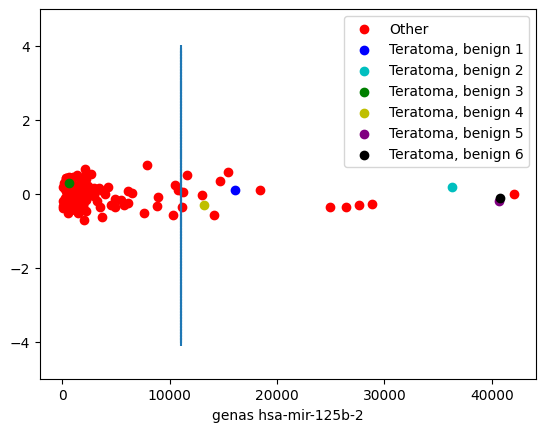

In [20]:
#i=np.where(gene_ids == 'hsa-mir-520f')[0][0]
i = 31


plt.scatter(X[6:139, i], np.random.normal(scale=0.3, size = len(X[6:139, 0])), c = 'r', label = 'Other')
plt.scatter(X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
plt.scatter(X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
plt.scatter(X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
plt.scatter(X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
plt.scatter(X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
plt.scatter(X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
plt.scatter(np.ones(100) * shifted_biases[i].numpy(), np.arange(start = -4, stop = 4, step = 8 / 100), marker = '|')
plt.xlabel('genas ' + str(gene_ids[i]))
plt.ylim(-5, 5)
plt.legend()
plt.show()

In [ ]:
i = 31


plt.scatter(transformed_X[6:139, i], np.random.normal(scale=0.3, size = len(transformed_X[6:139, 0])), c = 'r', label = 'Other')
plt.scatter(transformed_X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
plt.scatter(transformed_X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
plt.scatter(transformed_X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
plt.scatter(transformed_X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
plt.scatter(transformed_X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
plt.scatter(transformed_X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
#plt.scatter(np.ones(100) * shifted_biases[i].numpy(), np.arange(start = -4, stop = 4, step = 8 / 100), marker = '|')
#plt.scatter(np.ones(100) * model.first_layer_biases.data.numpy()[i], np.arange(start = -4, stop = 4, step = 8 / 100), marker = '|')
plt.xlabel('genas ' + str(gene_ids[i]))
plt.ylim(-5, 5)
plt.legend()
plt.show()

In [ ]:
print(torch.mean(features[:,25]))

tensor(0.7288)


In [ ]:
model = SparseNN(input_dim, temperature = 5)

loaded_first_layer_weights = torch.load("first_layer_weights.pt")
loaded_first_layer_biases = torch.load("first_layer_biases.pt")
loaded_otput_weights_raw = torch.load("output_weights_raw.pt")

# Assign the loaded values to the model
model.first_layer_weights.data = loaded_first_layer_weights
model.first_layer_biases.data = loaded_first_layer_biases
model.output_weights_raw.data = loaded_otput_weights_raw

probs = 100 * model(features).detach().numpy()
formatted_probs = np.array([f"{p:.2f}%" for p in probs])
print(formatted_probs)

['0.28%' '2.63%' '98.76%' '13.91%' '6.85%' '2.21%' '100.00%' '99.84%'
 '99.97%' '99.61%' '99.25%' '99.98%' '100.00%' '100.00%' '99.84%' '96.65%'
 '99.59%' '99.98%' '100.00%' '99.96%' '99.95%' '100.00%' '99.56%' '99.91%'
 '99.99%' '100.00%' '99.87%' '98.75%' '99.90%' '91.62%' '99.97%' '99.85%'
 '99.57%' '100.00%' '93.07%' '99.83%' '99.97%' '100.00%' '100.00%'
 '100.00%' '78.69%' '85.09%' '99.97%' '99.86%' '99.94%' '99.91%' '98.92%'
 '96.46%' '100.00%' '99.58%' '100.00%' '98.58%' '99.46%' '99.59%'
 '100.00%' '98.60%' '97.74%' '100.00%' '100.00%' '99.84%' '100.00%'
 '100.00%' '93.83%' '84.41%' '99.85%' '99.96%' '100.00%' '99.79%' '99.79%'
 '99.93%' '99.92%' '92.36%' '100.00%' '99.76%' '99.98%' '99.78%' '99.87%'
 '99.77%' '100.00%' '97.00%' '91.85%' '79.52%' '99.78%' '84.40%' '99.07%'
 '100.00%' '99.98%' '99.56%' '99.98%' '100.00%' '100.00%' '95.92%'
 '99.38%' '92.33%' '99.79%' '100.00%' '99.97%' '99.04%' '100.00%'
 '100.00%' '99.99%' '99.54%' '99.99%' '100.00%' '99.99%' '98.96%' '99.99%'


<ipython-input-84-6c24784f2594>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_first_layer_weights = torch.load("first_layer_weights.pt")
<ipython-input-84-6c24784f